In [73]:
# import required libraries
import pandas as pd
import numpy as np
from pymongo import MongoClient
import bert_serving.client as bert
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [74]:
"""
Database loading
"""
# define params for db operations 
uri = 'mongodb://localhost:27017/'
database = 'zs_database'
collection_fetch = 'autotags'
collection_push = 'labels'

# initiate variables
df = pd.DataFrame()
db = object

# connect to db. TODO: Handle exception cases
client = MongoClient(uri)
db = client[database]

# retrieving required data
df = pd.DataFrame(list(db[collection_fetch].find({}, {"_id":0, "lemmas": 1, "story_id": 1, "tokens": 1, "pos": 1, "nouns":1, "entities":1})))

df

,story_id,tokens,lemmas,pos,nouns,entities
0,19,"[Radio, ÜberAll, sendet, mal, ZukunftsmusikAm,...","[Radio, ÜberAll, senden, mal, ZukunftsmusikAm,...","[NOUN, PROPN, VERB, ADV, PROPN, PROPN, PROPN, ...","[Radio ÜberAll, ZukunftsmusikAm Mikrofon Krump...","[[Radio ÜberAll, MISC], [ZukunftsmusikAm Mikro..."
1,21,"[Dorf, pflanzt, SauerstoffMathilda, schaute, m...","[Dorf, pflanzen, SauerstoffMathilda, schauen, ...","[NOUN, VERB, PROPN, VERB, ADJ, NOUN, PROPN, AD...","[Unser Dorf, SauerstoffMathilda, dem Fenster G...","[[SauerstoffMathilda, MISC], [Das Thermometer ..."
2,24,"[langer, lebte, Witwer, einzigen, Tochter, Mut...","[lang, leben, Witwer, einzig, Tochter, Mutter,...","[ADJ, VERB, NOUN, ADJ, NOUN, NOUN, NOUN, VERB,...","[Es, ein Witwer, seiner einzigen Tochter, Die ...","[[Die Mutter des Mädchens, MISC], [warAlles, M..."
3,25,"[Beste, Partys, Buffet, findet, Bernd, steht, ...","[Beste, Party, Buffet, finden, Bernd, stehen, ...","[NOUN, PROPN, NOUN, VERB, PROPN, VERB, NOUN, N...","[Das Beste, Partys, das Buffet, Bernd Ihm, der...","[[Bernd Ihm, PER], [Lea, PER], [Papa, LOC], [W..."
4,27,"[Endlose, Laubwälder, saftige, Weiden, Wildblu...","[Endlose, Laubwälder, saftig, Weide, Wildblume...","[ADJ, NOUN, ADJ, ADJ, NOUN, ADJ, NOUN, VERB, A...","[Endlose Laubwälder, Wildblumenwiesen, wunders...","[[Endlose Laubwälder, PER], [Transsilvanien, L..."
...,...,...,...,...,...,...
195,489,"[Familie, Maus, verläßt, altes, HausErster, Su...","[Familie, Maus, verlassen, alt, HausErster, Su...","[NOUN, PROPN, VERB, ADJ, NOUN, NOUN, PROPN, NO...","[Familie Maus, ihr gutes altes HausErster Teil...","[[Familie Maus, PER], [HausErster, MISC], [Die..."
196,490,"[WolkenlandGlück, einst, Merkmal, Wolkenlandes...","[WolkenlandGlück, einen, Merkmal, Wolkenlandes...","[NOUN, ADV, NOUN, NOUN, NOUN, ADJ, NOUN, VERB,...","[Das WolkenlandGlück, ein Merkmal, des Wolkenl...","[[WolkenlandGlück, MISC], [Wolkenlandes Doch S..."
197,491,"[Tages, wacht, Miro, findet, komplett, Welt, s...","[Tag, wachen, Miro, finden, komplett, Welt, sc...","[NOUN, VERB, PROPN, VERB, ADJ, NOUN, ADJ, VERB...","[Eines Tages, Miro, eine komplett neue Welt, s...","[[Miro, LOC], [Miro, LOC], [Zeit vor dem Umwel..."
198,492,"[Goldene, Sonnenstrahlen, fielen, klare, Wasse...","[Goldene, Sonnenstrahlen, fallen, klaren, Wass...","[ADJ, NOUN, VERB, ADJ, NOUN, VERB, ADJ, NOUN, ...","[Goldene Sonnenstrahlen, die klare Wasseroberf...","[[Goldene Sonnenstrahlen, MISC], [Rhonda, LOC]..."


In [75]:
"""
Function: Using TF-IDF to extract key words in different Corpus.
"""

# input: list of string
# output: list of list of keywords 
def keyword(corpus, topK):
    
    key_list = []
    
    # Word frequency matrix 
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus) 
    
    # list of all words in Bag-of-Words model
    word = vectorizer.get_feature_names() 
    
    # TF-IDF Matrix
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(X)
    
    # weight[i][j] represents the weight of word j in text i
    weight = tfidf.toarray()
    
    for i in range(len(weight)):
        keys=[]
        zipped = zip(word,weight[i])
        sorted_l=sorted(zipped,key=lambda t:t[1],reverse=True)
        
        for n in range(topK):
            keys.append(sorted_l[n][0])
            
        key_list.append(keys)
    
    return key_list

In [76]:
"""
Term_Frequency—Count
"""
word_count = {}
for story in df['lemmas'].values.tolist():
    for token in story:
        if token.lower() in word_count:
            word_count[token.lower()] +=1
        else:
            word_count[token.lower()] =1
            
word_freq = []
for word,freq in word_count.items():
    word_freq.append((word,freq))
 
 
#sorted
word_freq.sort(key = lambda x:x[1],reverse = True)
num=len(word_freq)

# generate the most and least frequent words
most_freq=[]
least_freq=[]
for i in range(300):
    most_freq.append(word_freq[i][0])
    least_freq.append(word_freq[num-1-i][0])

    
print(most_freq)

['sehen', 'fragen', 'mal', 'stehen', 'mensch', 'finden', 'auge', 'hören', 'einfach', 'hand', 'baum', 'schauen', 'erde', 'denken', 'mutter', 'vater', 'rufen', 'haus', 'tier', 'leben', 'weg', 'kind', 'frau', 'eltern', 'kopf', 'mein', 'lassen', 'weiß', 'alt', 'wasser', 'welt', 'wald', 'halten', 'mama', 'schule', 'helfen', 'fahren', 'ziehen', 'laufen', 'erzählen', 'wissen', 'nächst', 'paar', 'liegen', 'nehmen', 'freund', 'papa', 'genau', 'bleiben', 'brauchen', 'setzen', 'glauben', 'luft', 'erklären', 'blick', 'essen', 'kommen', 'schnellen', 'sitzen', 'stellen', 'bringen', 'laut', 'schön', 'idee', 'sagen', 'sogar', 'zeigen', 'eigentlich', 'beginnen', 'bekommen', 'legen', 'boden', 'junge', 'verstehen', 'meinen', 'antworten', 'plötzlich', 'mann', 'lächeln', 'versuchen', 'scheinen', 'mädchen', 'fallen', 'meer', 'gesicht', 'fast', 'stimme', 'auto', 'langsam', 'nicken', 'müll', 'lisa', 'sprechen', 'drehen', 'geben', 'klimawandel', 'lachen', 'letzt', 'moment', 'fest', 'gehen', 'wusste', 'voll', '

In [77]:
"""
Text Cleaning:
Remove Remove entity's names,Propn and Adverbs
Might take some time
"""

frequent_verbs=[]
corpus = []
for i in range(len(df)):
    lemmas_l=[]
    persons=[]
    
    #entitie preprocessing:
    # We want to get rid of all the words which represents the name
    for m in range(len(df['entities'][i])):
        if df['entities'][i][m][1]=='PER':
            persons.append(df['entities'][i][m][0])
    
    # Here we already remove the propn, entity names and verbs
    for j in range(len(df['lemmas'][i])):
        if df['pos'][i][j]!="PROPN" and (df['lemmas'][i][j] not in persons)and (df['lemmas'][i][j].lower() not in most_freq) and df['pos'][i][j]!="ADV":
            lemmas_l.append(df['lemmas'][i][j])
    corpus.append(' '.join(lemmas_l))

In [221]:
"""
extract key words for each story : Top 15

Note:the words are not theme related and only present the elements of the story.
We could generate WordCloud to make it more visualize
"""
# it's possible to change the number of feature words here
result = keyword(corpus, 50)

for i in range(len(df)):
    print('Story ID:', df['story_id'][i], result[i])
    
df2=pd.DataFrame({'story_id':df['story_id'],'keywords':result})

df2.to_csv('Keywords.csv',encoding = 'ISO-8859-1')
df2

Story ID: 19 ['wolke', 'adama', 'bulk', 'kohlendioxid', 'spiegel', 'sonnenschirme', 'zukunftsmusik', 'atmosphäre', 'ägypter', 'pinguin', 'sonnenlicht', 'schwefel', 'co', 'radio', 'schützend', 'weltall', 'filter', 'umlaufbahn', 'ventil', 'senden', 'boot', 'mischung', 'einmachglas', 'saugen', 'hegen', 'reflektieren', 'surfen', 'forscher', 'vulkan', 'platzen', 'düngen', 'sonnenstrahlen', 'mond', 'segel', 'universum', 'fantasie', 'hülle', 'rand', 'adaes', 'adaja', 'adamakann', 'algenteppich', 'frups', 'funken', 'harnstoff', 'luftgemisch', 'schubser', 'sonnenschirmen', 'stratocumulus', 'stratosphäre']
Story ID: 21 ['dorf', 'bürgermeister', 'pflanzen', 'wettbewerb', 'assistent', 'pförtner', 'milliarde', 'kohlendioxid', 'rathaus', 'schneien', 'zahl', 'computer', 'taschenrechner', 'schwitzen', 'tüte', 'flugblatt', 'gießerei', 'pförtnerhäuschen', 'rasenmäher', 'umwandeln', 'auslachen', 'gruppe', 'mikrofon', 'berühmt', 'klimaneutral', 'lehrerpult', 'wars', 'klassenkameraden', 'kameramann', 'kübe

,story_id,keywords
0,19,"[wolke, adama, bulk, kohlendioxid, spiegel, so..."
1,21,"[dorf, bürgermeister, pflanzen, wettbewerb, as..."
2,24,"[frosch, stiefmutter, hexe, prinz, könig, feig..."
3,25,"[geist, schlafzimmer, wesen, lebensstil, himbe..."
4,27,"[vampir, ratte, beere, stall, see, burgruine, ..."
...,...,...
195,489,"[patsche, maus, moor, plastikteller, flitzer, ..."
196,490,"[wolkenland, tröpfchen, jüngling, bürger, umwe..."
197,491,"[erinnerung, empfänger, älteste, kindheitnumme..."
198,492,"[altvorderen, zone, kultur, pirat, ruine, boot..."



<p class="h4 alert alert-danger">
    Please make sure to install package wordcloud in the virtual environment
    pip install wordcloud
</p>


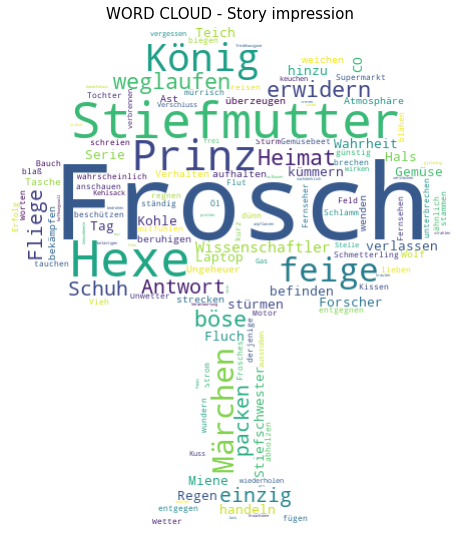

In [15]:
"""
Word Cloud generator
"""

from wordcloud import WordCloud, STOPWORDS
import re
from os import path
import string
from PIL import Image
import matplotlib.pyplot as plt

#change the index number here to make different wordclouds
index=2
# d = path.dirname(__file__)
alice_mask = np.array(Image.open("tree.png"))


wordcloud = WordCloud(
    background_color='white',
    max_words=200,
    max_font_size=120, 
    width=1000, height=800,
    random_state=42,
    mask=alice_mask
).generate(corpus[index]) #change the index number here to make different wordclouds

print(wordcloud)
fig = plt.figure(figsize = (8,10))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - Story impression",fontsize=15)
plt.axis('off')

plt.show()
filename='WordCloudID'+df['story_id'][index].astype('str')+'.jpg'
wordcloud.to_file(filename)


<p class="h4 alert alert-danger">
    Please make sure to download the pre-trained germen word2vec 
    and put it in the same path as the code
    http://cloud.devmount.de/d2bc5672c523b086
    
</p>


In [244]:
"""
extract key words for each story : Top 35
This is for the use of topic detection.

"""
# it's possible to change the number of feature words here
result = keyword(corpus, 35)

for i in range(len(df)):
    print('Story ID:', df['story_id'][i], result[i])
    
df3=pd.DataFrame({'story_id':df['story_id'],'keywords':result})

df3

Story ID: 19 ['wolke', 'adama', 'bulk', 'kohlendioxid', 'spiegel', 'sonnenschirme', 'zukunftsmusik', 'atmosphäre', 'ägypter', 'pinguin', 'sonnenlicht', 'schwefel', 'co', 'radio', 'schützend', 'weltall', 'filter', 'umlaufbahn', 'ventil', 'senden', 'boot', 'mischung', 'einmachglas', 'saugen', 'hegen', 'reflektieren', 'surfen', 'forscher', 'vulkan', 'platzen', 'düngen', 'sonnenstrahlen', 'mond', 'segel', 'universum']
Story ID: 21 ['dorf', 'bürgermeister', 'pflanzen', 'wettbewerb', 'assistent', 'pförtner', 'milliarde', 'kohlendioxid', 'rathaus', 'schneien', 'zahl', 'computer', 'taschenrechner', 'schwitzen', 'tüte', 'flugblatt', 'gießerei', 'pförtnerhäuschen', 'rasenmäher', 'umwandeln', 'auslachen', 'gruppe', 'mikrofon', 'berühmt', 'klimaneutral', 'lehrerpult', 'wars', 'klassenkameraden', 'kameramann', 'kübel', 'mähen', 'schlittenfahren', 'grad', 'angesichts', 'hängematte']
Story ID: 24 ['frosch', 'stiefmutter', 'hexe', 'prinz', 'könig', 'feige', 'weglaufen', 'märchen', 'stiefschwester', 'f

,story_id,keywords
0,19,"[wolke, adama, bulk, kohlendioxid, spiegel, so..."
1,21,"[dorf, bürgermeister, pflanzen, wettbewerb, as..."
2,24,"[frosch, stiefmutter, hexe, prinz, könig, feig..."
3,25,"[geist, schlafzimmer, wesen, lebensstil, himbe..."
4,27,"[vampir, ratte, beere, stall, see, burgruine, ..."
...,...,...
195,489,"[patsche, maus, moor, plastikteller, flitzer, ..."
196,490,"[wolkenland, tröpfchen, jüngling, bürger, umwe..."
197,491,"[erinnerung, empfänger, älteste, kindheitnumme..."
198,492,"[altvorderen, zone, kultur, pirat, ruine, boot..."


In [11]:
"""
Topic Selected: loading the pretrained word2vec model
source:https://github.com/devmount/GermanWordEmbeddings

this convert the word to a 300-dim vector
"""
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format("german.model", binary=True)
print(type(model))
# print(model['Kohlendioxid'])


<class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>


In [222]:
"""
Themes

"""
themes_no_map=['Ueberkonsum','importierte Lebensmittel']
themes=['Plastik', 'Strand', 'Biene', 'Kohlendioxid', 'Abholzung', 'Bergbau', 'Umweltverschmutzung', 'Flugzeug', 'Auto', 'Vegetarismus', 'Katastrophe', 'Fashion', 'Landwirtschaft', 'Pestizide', 'Tierschutz', 'Fabrik', 'Kohle', 'Brand', 'Tsunami', 'Meeresspiegelanstieg', 'Muelltrennung','Muellvermeidung']

In [274]:
"""
Generate the list of related topics for a specific given story
Output: list of tupels with topics and scores (the higher the more relevant)
Output_Name: topics

Attention: Some stories don't have any related topics, which should be ignored
"""

related={}

# here you can choose the story index
story_index = 146

for k in df3['keywords'][story_index]:
    
    #replace germen umlaut since the embedding has only english representation of umlaut
    k.replace("ä", "ae");
    k.replace("ü", "ue");
    k.replace("ö", "oe");
    k.replace("ß", "ss");
    
    #embedding dictionary keeps the Capital for nouns,but of tf-idf model makes the corpus uncased
    if k not in model:
        k=k.capitalize()
        if k not in model:
            continue
    for t in themes:
        if model.wv.similarity(k,t)>0.6: # Only words with enough similarity will be considered
            if t not in related:
                if model.wv.similarity(k,t)>0.74: #strongly similar word gets ticket immediately
                    related[t]=1
                elif t.lower() in k.lower() or k.lower() in t.lower(): #Containing Words. 
                    related[t]=1
                else:
                    related[t]=model.wv.similarity(k,t)
                print(k,t)
            else:
                related[t]+=model.wv.similarity(k,t)*0.6
                print(k,t)

# only scores higher than 1 would be considered       
topics=[]
for key, value in related.items():
    if value>=1:
        topics.append((key,value))
print(topics)



Schadstoff Kohlendioxid
Abgas Kohlendioxid
Klimaschutz Landwirtschaft
Klimaschutz Tierschutz
Klimaschutz Muellvermeidung
[('Kohlendioxid', 1.0824938654899596)]


/Users/a0000/anaconda3/envs/JS20/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/Users/a0000/anaconda3/envs/JS20/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/Users/a0000/anaconda3/envs/JS20/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/Users/a0000/anaconda3/envs/JS20/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [265]:
# Validation recommendation: Nr.72, 189...